#**Import libraries**

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re  # for pattern matching and text manipulation.
import string
import nltk
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# **Loading Data**

In [42]:
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/codesoft/Genre Classification Dataset/train_data.txt",
                        sep=':::', names=["title", "genre", "description"], engine='python')
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/codesoft/Genre Classification Dataset/test_data.txt",
                        sep=':::', names=["title", "description"], engine='python')

# **Data Visualizaion**

In [43]:
train_data.head()

,title,genre,description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [44]:
test_data.head()

,title,description
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...


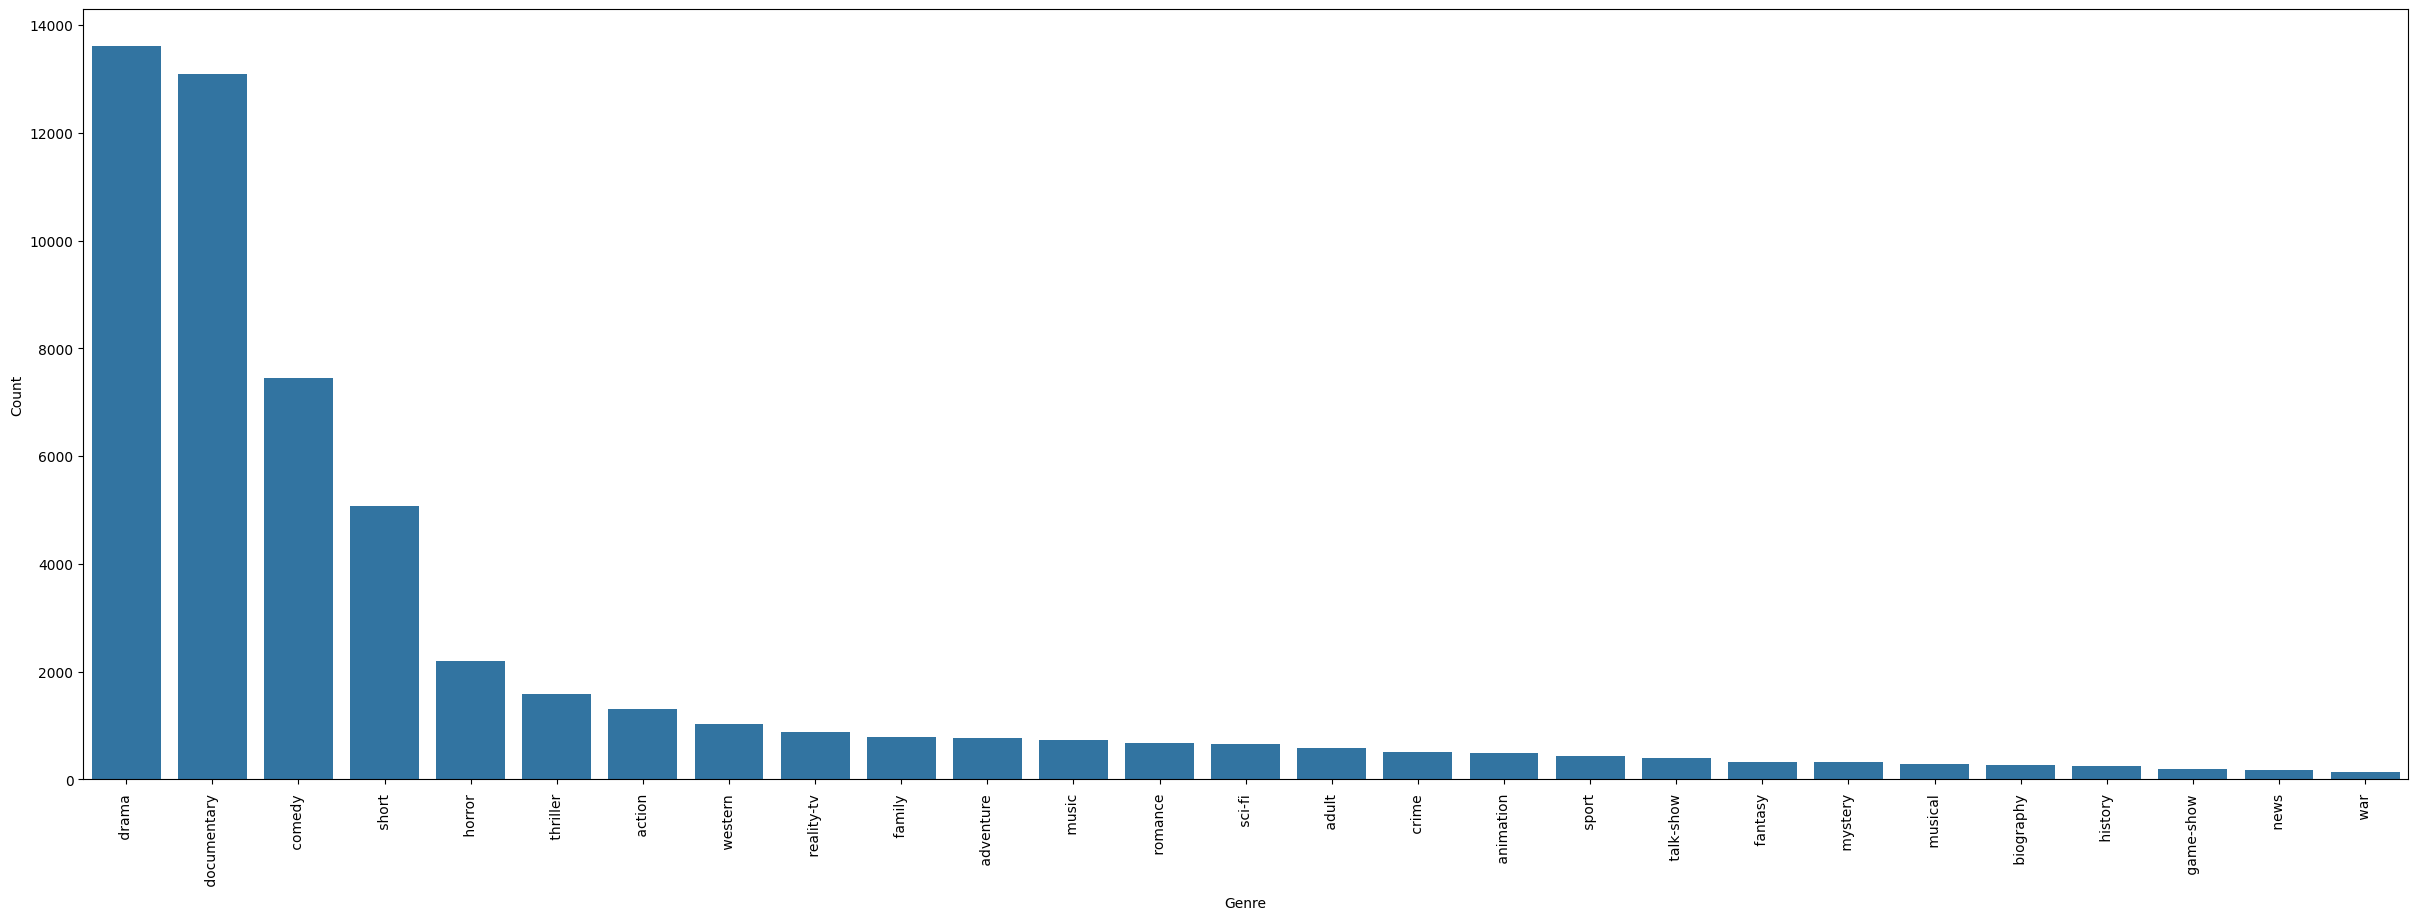

In [45]:
plt.figure(figsize=(30,10))
counts = train_data.genre.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90);

In [46]:
train_data.describe()

,title,genre,description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [47]:
train_data.genre.value_counts()

 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: genre, dtype: int64

# **Data Cleaning & Preprocessing**

In [48]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        54214 non-null  object
 1   genre        54214 non-null  object
 2   description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [49]:
train_data.isnull().sum()

title          0
genre          0
description    0
dtype: int64

In [50]:
print("shape before drop nulls",train_data.shape)

# Droping the redundant data
train_data = train_data.drop_duplicates()
print("shape after drop nulls",train_data.shape)

shape before drop nulls (54214, 3)
shape after drop nulls (54214, 3)


# **Text Cleaning**

In [51]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [52]:
stop_words = set(stopwords.words('english')) # stop words
def clean_data(text):
    text = text.lower()
    text = re.sub(r'@\S+','',text)                       # [1] remove mentions
    text = re.sub(r'http\S+', '', text)                  # [2] remove urls
    text = re.sub(r'[\w\.-]+@[\w\.-]+',"",text)          # [3] remove emails
    text = re.sub(r"[^a-zA-Z+']", ' ', text)             # [4] keep only english chars / remove numbers
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # [5] remove single chars
    text = re.sub(r'pic.\S+', '',text)                   # [6]
    text = re.sub(r'#', "", text)                        # [7] remove hashtags
    text = re.sub(r"_", "  ", text)                      # [8] remove hashtags
    text = re.sub('\n'," . ",text)                       # [9] remove new lines
    text = re.sub('\[[^]]*\]','',text)                   # [10] remove square prackets
    text = "".join([char for char in text if char not in string.punctuation]) # [11] remove punctuations
    text= re.sub("\s[\s]+", " ",text).strip()            # [12] remove repeated/leading/trailing spaces
    tokens = word_tokenize(text)                         # [13] Tokenize
    text = " ".join([word for word in tokens if word not in stop_words and len(word) > 2]) # [14] remove stop words

    return text

# **Some Data Statistics**

In [53]:
train_data['description_cleaned'] = train_data['description'].apply(clean_data)
test_data['description_cleaned'] = test_data['description'].apply(clean_data)

In [54]:
st = PorterStemmer()
train_data['description_cleaned'] = train_data['description_cleaned'].apply(
    lambda x: ' '.join([st.stem(word) for word in x.split()]))

test_data['description_cleaned'] = test_data['description_cleaned'].apply(
    lambda x: ' '.join([st.stem(word) for word in x.split()]))

In [55]:
train_data['length']=train_data['description'].apply(len)
train_data['length_cleaned']=train_data['description_cleaned'].apply(len)
train_data.head()

,title,genre,description,description_cleaned,length,length_cleaned
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listen convers doctor parent year old oscar le...,546,339
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestu relationship curre...,184,111
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bu empti student field trip museum natur histo...,650,344
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemploy father make end meet edith twin ...,1082,678
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film titl refer recov bodi ground zero also st...,625,347


In [56]:
print("Average Length of Text Before Cleaning: ", train_data['length'].mean())
print("Average Length of Text After Cleaning: ", train_data['length_cleaned'].mean())

Average Length of Text Before Cleaning:  600.4524292618142
Average Length of Text After Cleaning:  360.2900542295348


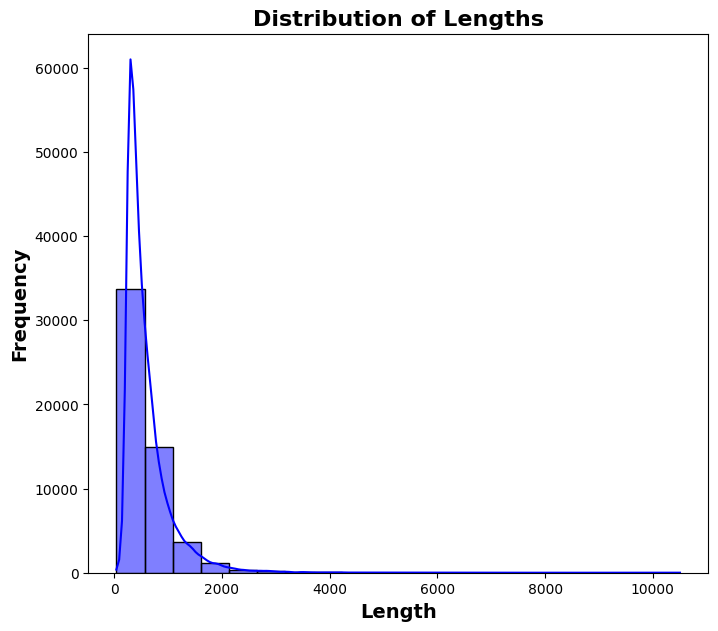

In [57]:
plt.figure(figsize=(8, 7))

sns.histplot(data=train_data, x='length', bins=20, kde=True, color='blue')

plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')

plt.show()

# **Get Top bigrams**

In [58]:
def get_top_n_bigram(corpus, n=None):
    vec = CV(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

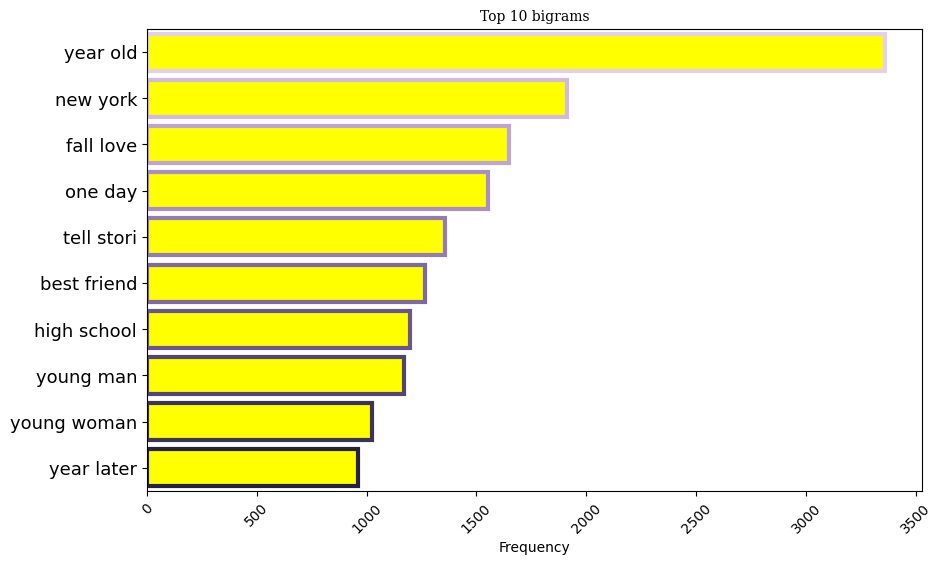

In [59]:
common_words = get_top_n_bigram(train_data['description_cleaned'], 10)
common_words_df = pd.DataFrame(common_words,columns=['word','freq'])
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='freq', y='word', data=common_words_df,facecolor='yellow',linewidth=3,edgecolor=sns.color_palette("ch:start=3, rot=.1",10))

plt.title("Top 10 bigrams",font='Serif')
plt.xlabel("Frequency", fontsize=10)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=10)
plt.ylabel("");

# **Label Encodeing of the Target variable**

In [60]:
le = LabelEncoder()
train_data['genre'] = le.fit_transform(train_data['genre'].values)

# keep only relevent columns
train_df = train_data.loc[:,['description_cleaned', 'genre']]
test_df = test_data.loc[:,['description_cleaned', 'title']]
train_df.head(10)

,description_cleaned,genre
1,listen convers doctor parent year old oscar le...,8
2,brother sister past incestu relationship curre...,24
3,bu empti student field trip museum natur histo...,1
4,help unemploy father make end meet edith twin ...,8
5,film titl refer recov bodi ground zero also st...,8
6,qualiti control consist seri singl take shot f...,7
7,tough econom time max joey run idea discov sen...,5
8,ron petri keanu reev troubl teen whose life ha...,6
9,sudden calamit event caus great loss life dama...,18
10,four high school student embark terrifi journe...,13


# **Train Test Split**

In [61]:
train_set , val_set , train_label , val_label = train_test_split(train_df['description_cleaned'] , train_data['genre'] , test_size=0.2 , shuffle=True , random_state = 42)

print(f'Split data into train and eval sets')
print(f'Trani Set\t: {len(train_set)}\nValidation Set\t: {len(val_set)}')

Split data into train and eval sets
Trani Set	: 43371
Validation Set	: 10843


# **Feature Extraction**

In [62]:
# using TF-IDF
vectorize = TfidfVectorizer(stop_words='english', max_features=100000)
train_set_tfidf = vectorize.fit_transform(train_set)
val_set_tfidf = vectorize.transform(val_set)

# **Models Training and Evaluation**

# **[1] Logistic Regression Model (LR)**

In [63]:
LR_model = LogisticRegression()
LR_model.fit(train_set_tfidf, train_label)
predict_LR = LR_model.predict(val_set_tfidf)
print(classification_report(val_label, predict_LR))
LR_accuracy = accuracy_score(predict_LR,val_label)
print('Logistic Regression accuracy is: {:.2f}%'.format(LR_accuracy*100))

              precision    recall  f1-score   support

           0       0.52      0.28      0.37       263
           1       0.82      0.29      0.42       112
           2       0.40      0.12      0.19       139
           3       0.38      0.03      0.05       104
           4       0.00      0.00      0.00        61
           5       0.52      0.58      0.55      1443
           6       0.20      0.02      0.03       107
           7       0.66      0.84      0.74      2659
           8       0.53      0.79      0.64      2697
           9       0.42      0.09      0.15       150
          10       0.00      0.00      0.00        74
          11       0.91      0.50      0.65        40
          12       0.00      0.00      0.00        45
          13       0.66      0.57      0.61       431
          14       0.67      0.46      0.55       144
          15       0.00      0.00      0.00        50
          16       0.00      0.00      0.00        56
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

# **[2] Multinomial Naive Bayes Model** **(MultinomialNB)**

In [64]:
# Train a Naive Bayes classifier
NB_model = MultinomialNB()
NB_model.fit(train_set_tfidf, train_label)
y_pred_naive = NB_model.predict(val_set_tfidf)
print(classification_report(val_label, y_pred_naive))
naive_accuracy = accuracy_score(y_pred_naive,val_label)
print('Naive Bayes model accuracy is: {:.2f}%'.format(naive_accuracy*100))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       263
           1       0.00      0.00      0.00       112
           2       0.00      0.00      0.00       139
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00        61
           5       0.66      0.05      0.09      1443
           6       0.00      0.00      0.00       107
           7       0.51      0.89      0.65      2659
           8       0.38      0.87      0.53      2697
           9       0.00      0.00      0.00       150
          10       0.00      0.00      0.00        74
          11       0.00      0.00      0.00        40
          12       0.00      0.00      0.00        45
          13       0.00      0.00      0.00       431
          14       0.00      0.00      0.00       144
          15       0.00      0.00      0.00        50
          16       0.00      0.00      0.00        56
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **[3] Support Vector Machine Model (SVC)**

In [65]:
# Train a SVC classifier
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(train_set_tfidf, train_label)
predict = svm_model.predict(val_set_tfidf)

print(classification_report(val_label, predict))
svm_accuracy = accuracy_score(predict,val_label)
print('SVC model accuracy is: {:.2f}%'.format(svm_accuracy*100))

              precision    recall  f1-score   support

           0       0.46      0.33      0.39       263
           1       0.68      0.44      0.53       112
           2       0.39      0.21      0.27       139
           3       0.38      0.13      0.20       104
           4       0.00      0.00      0.00        61
           5       0.53      0.58      0.55      1443
           6       0.22      0.06      0.09       107
           7       0.68      0.80      0.73      2659
           8       0.55      0.71      0.62      2697
           9       0.37      0.15      0.22       150
          10       0.40      0.05      0.10        74
          11       0.83      0.62      0.71        40
          12       0.25      0.02      0.04        45
          13       0.60      0.63      0.61       431
          14       0.55      0.53      0.54       144
          15       0.27      0.06      0.10        50
          16       0.00      0.00      0.00        56
          17       0.29    

# **Butting all together.**

In [66]:
columns=['LogisticRegression', 'MultinomialNB','Support Vector Machine']
accuracy= [LR_accuracy, naive_accuracy, svm_accuracy]

FinalResult=pd.DataFrame({'Algorithm':columns, 'Accuracy':accuracy})

FinalResult

,Algorithm,Accuracy
0,LogisticRegression,0.578438
1,MultinomialNB,0.441022
2,Support Vector Machine,0.571336


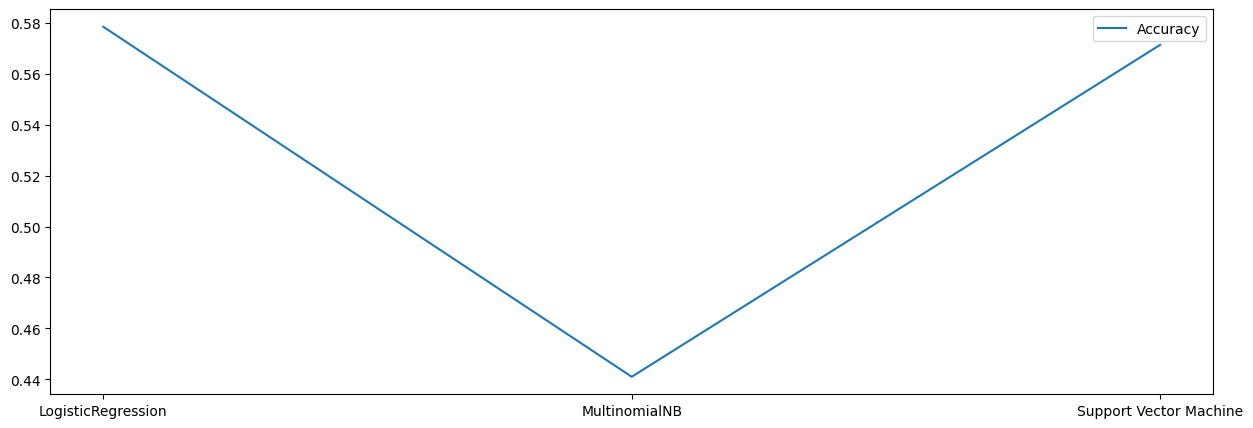

In [67]:
fig,ax=plt.subplots(figsize=(15,5))
plt.plot(FinalResult.Algorithm,accuracy,label="Accuracy")
plt.legend()
plt.show()